### ASTR 3970 / 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 4
### Due: Saturday, Feb 15th at 11.59pm CST
---

## Problem 1

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

#### 1) Read in `hw4_data_1.npy`. This is a (10 x 2) numpy array, with voltage measurements in the first column and heteroscedastic voltage uncertainties in the second column. Compute the sample mean and the standard error on the sample mean for this data.

### Solution

MEK: Import block

In [1]:
import numpy as np
import scipy
from scipy import optimize
from scipy import stats
from matplotlib import pyplot as plt
from scipy.integrate import quad
import corner.corner as corner

MEK: Read in data and separate it into its respective columns.

In [2]:
hw4data1 = np.load("./../../homeworks/hw_data/hw4_data_1.npy")
voltage = hw4data1[:,0]
uncert = hw4data1[:,1]

MEK: Calculate mean and error on the mean from Lecture 5 on heteroschedastic Gaussian distributions

In [3]:
mean = (np.sum(voltage/uncert**2))/(np.sum(1/uncert**2))
error = (np.sum(1/uncert**2))**(-1/2)

print("Mean:", "%.4f"%mean)
print("Error on mean:", "%.4f"%error)

Mean: 4.9421
Error on mean: 0.4302


#### 2) Fit the appropriate ln-likelihood function and find the best-fit mean voltage.

MEK: Grab code block from MEK HW3

In [4]:
# MEK heteroschedastic Gaussian ln(likelihood) function - make it negative because optimize.fmin minimizes functions
def het_G(mu, sigma, x):
    num = -1*((x-mu)**2)
    denom = 2*(sigma**2)
    lnL = num/denom
    lnL = np.sum(num/denom)
    const = np.sum(np.log(1/(sigma*np.sqrt(2*np.pi))))
    lnL += const
    lnL *= -1
    return lnL

# MEK define a function that will optimize the mean, given certain data
fit = lambda beta: het_G(beta[0], uncert, voltage)

# MEK compute the maximum likelihood 
beta = mean
beta_fit, lnL_G_max, it_G, evals_G, warn_G = optimize.fmin(fit, beta, full_output=True)

print("Best-fit mean =", "%.4f"%beta_fit[0])

Optimization terminated successfully.
         Current function value: 16.048013
         Iterations: 13
         Function evaluations: 26
Best-fit mean = 4.9421


#### 3) Compute and plot the Bayesian posterior probability density (*not the log posterior*) for the mean voltage assuming a uniform prior for the mean in the range 3.5 to 6.5. Make sure this posterior pdf is normalized!

MEK: Formulate grid of proposed means to look over, define a likelihood and prior, normalize by dividing by area, plot

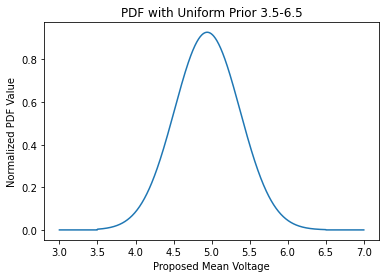

In [5]:
xgrid = np.linspace(3, 7, 1000)

def het_G_likelihood(mu, sigma, x):
    num = -1*((x-mu)**2)
    denom = 2*(sigma**2)
    lnL = num/denom
    lnL = np.sum(num/denom)
    const = np.sum(np.log(1/(sigma*np.sqrt(2*np.pi))))
    lnL += const
    L = np.e**lnL
    return L

def uniform_prior(x, loc, scale):
    prior = scipy.stats.uniform(loc, scale)
    pdf = prior.pdf(x)
    return pdf

like = [het_G_likelihood(x, uncert, voltage) for x in xgrid]
prior = uniform_prior(xgrid, 3.5, 3)
prob3 = like*prior
evid3 = scipy.integrate.trapezoid(prob3, xgrid)
prob3 /= evid3
plt.plot(xgrid, prob3)
plt.title("PDF with Uniform Prior 3.5-6.5")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("Normalized PDF Value")
plt.show()

#### 4) By either drawing samples from this posterior, or using your gridded posterior pdf to make a cdf, find the equal-tailed 68.3% credible region for the mean, and compare the upper and lower boundaries to $\mu+\sigma_\mathrm{mean}$ and $\mu-\sigma_\mathrm{mean}$. *Also* find the MAP value of the mean.

MEK: Cumulative sum of pdf will give cdf scaling, normalize by dividing by the final value in the array, plot $1\sigma$ lines

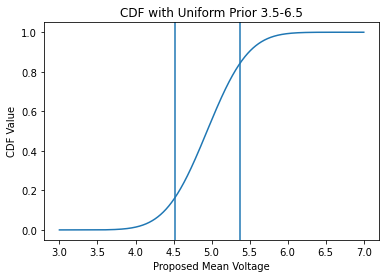

MAP: 4.9419


In [6]:
cdf = np.cumsum(prob3)
cdfnorm = cdf[-1]
cdf /= cdfnorm

credible_low = np.where(cdf>0.1585)[0][0]
credible_high = np.where(cdf>0.8415)[0][0]

x_low = xgrid[credible_low]
x_high = xgrid[credible_high]

plt.axvline(x_low)
plt.axvline(x_high)
plt.plot(xgrid, cdf)
plt.title("CDF with Uniform Prior 3.5-6.5")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("CDF Value")
plt.show()

map = xgrid[np.where(prob3==np.max(prob3))[0]][0]
print("MAP:", "%.4f"%map)

#### 5) Repeat (3) and (4) this time with a prior on the mean that is uniform in the range 4.5 to 5.5. 

MEK: Repeat with new prior (more constrained)

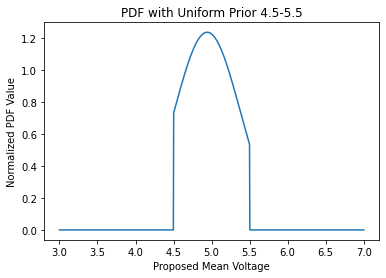

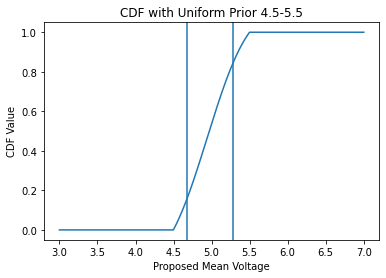

MAP: 4.9419


In [7]:
like = [het_G_likelihood(x, uncert, voltage) for x in xgrid]
prior = uniform_prior(xgrid, 4.5, 1)
prob5 = like*prior
evid5 = scipy.integrate.trapezoid(prob5, xgrid)
prob5 /= evid5
plt.plot(xgrid, prob5)
plt.title("PDF with Uniform Prior 4.5-5.5")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("Normalized PDF Value")
plt.show()

cdf = np.cumsum(prob5)
cdfnorm = cdf[-1]
cdf /= cdfnorm

credible_low = np.where(cdf>0.1585)[0][0]
credible_high = np.where(cdf>0.8415)[0][0]

x_low = xgrid[credible_low]
x_high = xgrid[credible_high]

plt.axvline(x_low)
plt.axvline(x_high)
plt.plot(xgrid, cdf)
plt.title("CDF with Uniform Prior 4.5-5.5")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("CDF Value")
plt.show()

map = xgrid[np.where(prob5==np.max(prob5))[0]][0]
print("MAP:", "%.4f"%map)

#### 6) Now, imagine that we read an old paper about the experiment that gave us the voltage measurements, and they found that the mean was actually $6.1\pm0.25$. Repeat (3) and (4) this time with a Gaussian prior on the mean centered at $6.1$ with standard deviation of $0.25$.

MEK: Repeat with new Gaussian prior -- it's cool how it moves the peak of the distribution over, but not all the way to 6.1!

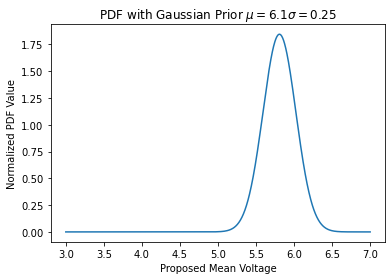

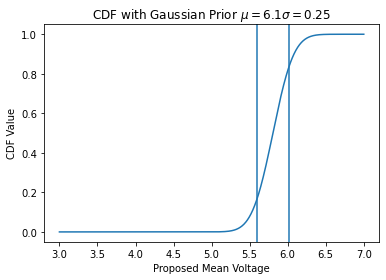

MAP: 5.8068


In [8]:
def gaussian_prior(x, loc, scale):
    prior = scipy.stats.norm(loc, scale)
    pdf = prior.pdf(x)
    return pdf

like = [het_G_likelihood(x, uncert, voltage) for x in xgrid]
prior = gaussian_prior(xgrid, 6.1, 0.25)
prob6 = like*prior
evid6 = scipy.integrate.trapezoid(prob6, xgrid)
prob6 /= evid6
plt.plot(xgrid, prob6)
plt.title(r"PDF with Gaussian Prior $\mu=6.1 \sigma=0.25$")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("Normalized PDF Value")
plt.show()

cdf = np.cumsum(prob6)
cdfnorm = cdf[-1]
cdf /= cdfnorm

credible_low = np.where(cdf>0.1585)[0][0]
credible_high = np.where(cdf>0.8415)[0][0]

x_low = xgrid[credible_low]
x_high = xgrid[credible_high]

plt.axvline(x_low)
plt.axvline(x_high)
plt.plot(xgrid, cdf)
plt.title(r"CDF with Gaussian Prior $\mu=6.1 \sigma=0.25$")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("CDF Value")
plt.show()

map = xgrid[np.where(prob6==np.max(prob6))[0]][0]
print("MAP:", "%.4f"%map)

#### 7) Plot all of the normalized posterior pdfs for $\mu$ from (3), (5), and (6) on the same plot, making sure that the xlim of the plot spans 0 to 10.

MEK: Plot all together -- notice how taller ones are skinnier and vice versa (because they're all normalized in area). Also cool!

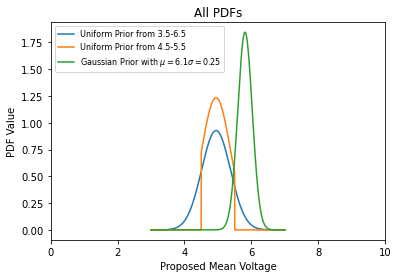

In [9]:
plt.plot(xgrid, prob3, label="Uniform Prior from 3.5-6.5")
plt.plot(xgrid, prob5, label="Uniform Prior from 4.5-5.5")
plt.plot(xgrid, prob6, label=r"Gaussian Prior with $\mu=6.1 \sigma=0.25$")
plt.xlim(0,10)
plt.title("All PDFs")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("PDF Value")
plt.legend(loc=2, fontsize=8)
plt.show()

#### 8) You have made sure that the posterior pdfs are properly normalized, but until now you have ignored the meaning of that normalization constant. It is the Bayesian evidence for the particular model you have applied! Compute the evidence under a new model where the prior for the mean is a delta function at the best-fit value you found in (1) *(think about this and don't just immediately go looking for a `scipy.stats` delta function)*. Compare this to the evidence found under the prior in (3). Taking ratios to make a Bayes factor, which model is favored? Is there much of an Occam penalty by having the wide prior compared to knowing the mean exactly?

MEK: Define a delta prior (couldn't look for a x-$\mu$ difference of 0 because then I got no results for a perfect match, instead went for a low value like $10^{-3}$), follow same procedure as previous questions

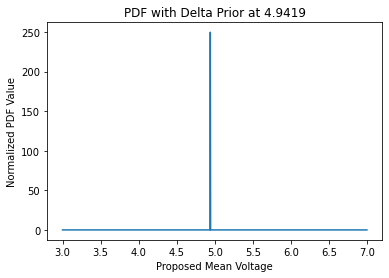

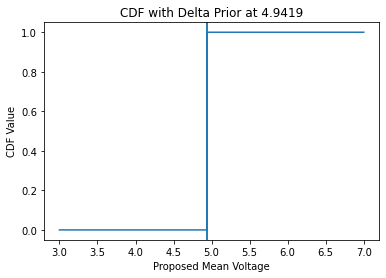

MAP: 4.9419


In [10]:
def delta_prior(x, mu):
    match = np.where(np.abs(x-mu)<1e-3, 1, 0)
    return match

like = [het_G_likelihood(x, uncert, voltage) for x in xgrid]
prior = delta_prior(xgrid, mean)
prob8 = like*prior
evid8 = scipy.integrate.trapezoid(prob8, xgrid)
prob8 /= evid8
plt.plot(xgrid, prob8)
plt.title("PDF with Delta Prior at 4.9419")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("Normalized PDF Value")
plt.show()

cdf = np.cumsum(prob8)
cdfnorm = cdf[-1]
cdf /= cdfnorm

credible_low = np.where(cdf>0.1585)[0][0]
credible_high = np.where(cdf>0.8415)[0][0]

x_low = xgrid[credible_low]
x_high = xgrid[credible_high]

plt.axvline(x_low)
plt.axvline(x_high)
plt.plot(xgrid, cdf)
plt.title(r"CDF with Delta Prior at 4.9419")
plt.xlabel("Proposed Mean Voltage")
plt.ylabel("CDF Value")
plt.show()

map = xgrid[np.where(prob8==np.max(prob8))[0]][0]
print("MAP:", "%.4f"%map)

MEK: Calculate Bayes factor to compare 1.3 to 1.8

In [11]:
print("Evidence from part 3:", evid3)
print("Evidence from part 8:", evid8)

bayes = evid3/evid8
print("Bayes factor of part 3 to part 8:", "%.4f"%bayes)

Evidence from part 3: 3.853757800232332e-08
Evidence from part 8: 4.294682862361151e-10
Bayes factor of part 3 to part 8: 89.7332


MEK: 89 is greater than 30 but less than 100, so we say that part 3 is favored strongly but not decisively!

MEK: Define an Occam penalty function as well as a BIC function, use these for further comparison of 1.3 to 1.8

In [12]:
def occam(n, k):
    return k*np.log(n)
    
def bic(maxL, n, k):
    return -2*np.log(maxL)+occam(n,k)

n = np.shape(xgrid)
bic3 = bic(np.max(prob3), n, 2)
bic8 = bic(np.max(prob8), n, 1)
print("BIC for part 3:", "%.4f"%bic3)
print("BIC for part 8:", "%.4f"%bic8)

occam3 = occam(n, 2)
occam8 = occam(n, 1)
print("Penalty for part 3:", "%.4f"%occam3)
print("Penalty for part 8:", "%.4f"%occam8)

BIC for part 3: 13.9655
BIC for part 8: -4.1332
Penalty for part 3: 13.8155
Penalty for part 8: 6.9078


/tmp/ipykernel_180866/1828647742.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("BIC for part 3:", "%.4f"%bic3)
/tmp/ipykernel_180866/1828647742.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("BIC for part 8:", "%.4f"%bic8)
/tmp/ipykernel_180866/1828647742.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Penalty for part 3:", "%.4f"%occam3)
/tmp/ipykernel_180866/1828647742.py:16: DeprecationWarning: Conversion of an array with ndi

## Problem 2

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

#### 1) Read in `hw4_data_2.npy`, which is a (3 x 20) numpy array that you used in `Lecture_9`. Set `x, y, sigma_y = data`. We're going to do some polynomial fits to this data just like in `Lecture 9`. However, in all cases you should **keep the $y$-intercept fixed at $-0.23$**. 

### Solution

MEK: Read in data and separate it into its respective columns, define a y-intercept that won't change throughout this approach

In [13]:
hw4data2 = np.load("./../../homeworks/hw_data/hw4_data_2.npy")
x, y, sigma_y = hw4data2
b = -0.23

#### 2) Use the following code to compute the un-normalized posterior pdf (i.e. just the likelihood x prior) on a grid of the linear coefficient (i.e. the slope) of a linear model, with a uniform prior between 0.5 and 1.5. Plot this posterior pdf. Remember this is just a one-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100.

MEK: Start from SRT hints for functions, define a proposed slope array (called m_array) and find posterior

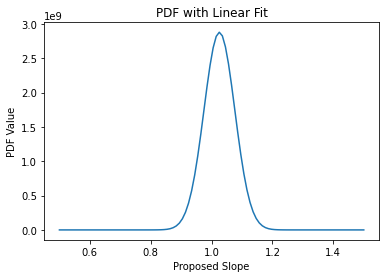

In [14]:
#Functions to do a polynomial fit, and compute the likelihood
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For a polynomial with order 1, this gives theta_0 + theta_1*x
    # For a polynomial with order 2, this gives theta_0 + theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(scipy.stats.norm.logpdf(*args) 
               for args in zip(y, y_fit, sigma_y))

m_array = np.linspace(0.5, 1.5, 100)
prior_linear = uniform_prior(m_array, 0.5, 1)

logl = np.array([logL([b, m], hw4data2) for m in m_array])
l = np.e**(logl)
post_linear = l*prior_linear
plt.plot(m_array, post_linear)
plt.title(r"PDF with Linear Fit")
plt.xlabel("Proposed Slope")
plt.ylabel("PDF Value")
plt.show()

#### 3) Using your 1D gridded likelihood-x-prior, compute the Bayesian evidence of this linear model. This may be a big number!

MEK: Integrate under curve to find evidence (big number!)

In [15]:
evid_linear = scipy.integrate.trapezoid(post_linear, m_array)
print("Linear evidence:", "%.4f"%evid_linear)

Linear evidence: 365684733.1607


#### 4) Now compute the joint 2D posterior pdf (again just the likelihood x prior) of linear and quadratic coefficients of a quadratic model. Give the linear coefficient a uniform prior between 0.5 and 1.5. Give the quadratic coefficient a uniform prior between -1 and 0.25. Plot this two-dimensional posterior. Remember this is a two-dimensional model because the $y$-intercept is fixed. I advise a grid size of 100 in each model dimension. 

MEK: Define linear (m_array) and quadratic (a_array) proposed coefficient arrays to test, define uniform priors for both and calculate likelihood. This takes some time, but not too much. I separated this cell from the rest of the math so that I didn't have to rerun the time-consuming line multiple times as I wrote this homework

In [16]:
m_array = np.linspace(0.5, 1.5, 100)
a_array = np.linspace(-1, 0.25, 100)

m_prior_quad = uniform_prior(m_array, 0.5, 1)
a_prior_quad = uniform_prior(a_array, -1, 1.25)

logl_quad = np.array([[logL([b, m, a], hw4data2) for m in m_array]for a in a_array])
l_quad = np.e**(logl_quad)

MEK: Calculate posterior from likelihood and prior, plot. The posterior appears to have some level of symmetry between m and a, but I can't think of an intuitive reason why this would make sense to see.

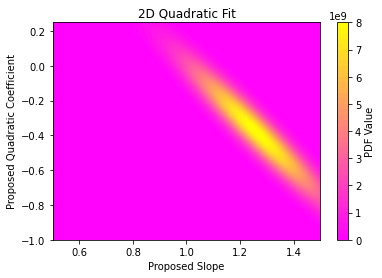

In [17]:
m_post_quad = l_quad*m_prior_quad
a_post_quad = l_quad*a_prior_quad

plt.contourf(m_array, a_array, l_quad, levels=50, cmap="spring")
plt.colorbar(label="PDF Value")
plt.title(r"2D Quadratic Fit")
plt.xlabel("Proposed Slope")
plt.ylabel("Proposed Quadratic Coefficient")
plt.show()

#### 5) Using your 2D gridded likelihood-x-prior, compute the Bayesian evidence of the quadratic model. 

MEK: Integrate over both axes (I don't think order matters as the symmetry is already demonstrated) to calculate evidence (another big number, but similar order of magnitude)

In [18]:
evid_quad = scipy.integrate.trapezoid(l_quad, m_array)
evid_quad = scipy.integrate.trapezoid(evid_quad, a_array)
print("Quadratic evidence:", "%.4f"%evid_quad)

Quadratic evidence: 613042113.2712


#### 6) Calculate the Bayes factor for a linear versus quadratic model. How does this compare/contrast with the BIC model comparison in Lecture 9?

MEK: Compare linear and quadratic approach via Bayes factor and BIC. Bayes factor seems to favor the quadratic approach with substantial but not strong evidence (different by more than a factor of 1 but less than a factor of 10). BIC favors the linear model (more negative) but not by much, comparatively. In the Lecture 9 example, the quadratic model was favored over the linear model but below the cubic model in overall $\chi^2$, but was favored overall in the $\chi^2$ per degree of freedom. Here, the quadratic approach is favored until we factor in degrees of freedom, then the linear model is favored.

In [19]:
bayes = evid_linear/evid_quad
print("Bayes factor of part 3 to part 8:", "%.4f"%bayes)

n = 100
bic_lin = bic(np.max(post_linear),n,1)
bic_quad = bic(np.max(l_quad),n,2)

print("BIC for linear model:", "%.4f"%bic_lin)
print("BIC for quadratic model:", "%.4f"%bic_quad)

Bayes factor of part 3 to part 8: 0.5965
BIC for linear model: -38.9555
BIC for quadratic model: -36.3894
